In [ ]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10609 sha256=f7664e8c5208cd84ccf3d25cd081970fdb0822af0e36a22ea7e331575c799b87
  Stored in directory: /root/.cache/pip/wheels/b4/aa/7a/d9a88098f7877aa95dd4f227fe614f75773654baa39b47bba6
Successfully built minisom


In [2]:
## for data
import numpy as np
import pandas as pd
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for geospatial
import folium
import geopy
## for machine learning
from sklearn import preprocessing, cluster
import scipy
## for deep learning
import minisom

In [3]:
!pip install geopandas
!pip install geopy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import requests
import urllib.parse
import geopy
import geopandas
from geopy.geocoders import Nominatim

In [6]:
import json
import csv

locator = Nominatim(user_agent = "hi")
## 
##
##
##
## To make this notebook run on json instead of training data, uncomment the next line 


#dtf = pd.read_json('data.json')
dtf = pd.read_csv('/content/Training.csv') # delete this line to run on JSON
#
#
#
#
#
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column

dtf['ADDRESS'] = dtf['street'] + ' ' + dtf['city']
dtf['location'] = dtf['ADDRESS'].apply(geocode) 


# 3 - create longitude, laatitude and altitude from location column (returns tuple)
dtf['point'] = dtf['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
dtf[['latitude', 'longitude', 'altitude']] = pd.DataFrame(dtf['point'].tolist(), index=dtf.index)



dtf = dtf[dtf["city"]=="DALLAS"][["city","street","longitude","latitude","products"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id"})
dtf.head()

,id,city,street,longitude,latitude,products
0,0,DALLAS,5147 Horseshoe Trail,-96.824669,32.858755,2
1,1,DALLAS,2900 Botham Jean Blvd,-96.797714,32.769288,1
2,2,DALLAS,3924 Gillon Ave.,-96.798793,32.829524,4
3,3,DALLAS,2800 Douglas Ave.,-96.814717,32.810770,5
4,4,DALLAS,3025 Bryan St.,-96.788096,32.791826,3


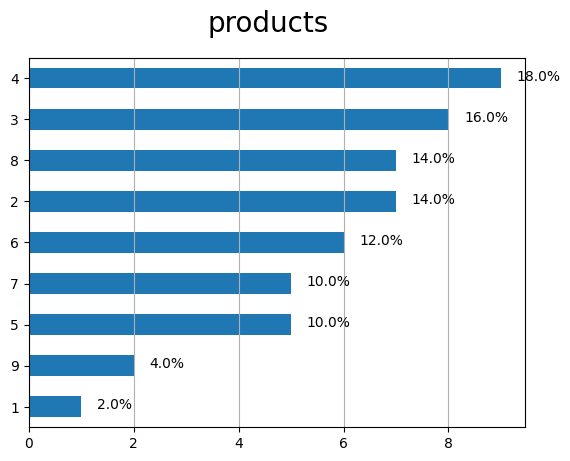

In [7]:
x = "products"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

In [8]:
city = "Dallas"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Dallas, Dallas County, Texas, United States
[lat, long]: [32.7762719, -96.7968559]


Affinity Propagation 


In [9]:
model = cluster.AffinityPropagation()

<ipython-input-11-73da76e958c5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_X["centroids"].iloc[i] = 1


Text(0.5, 1.0, 'Affininty Propagation')

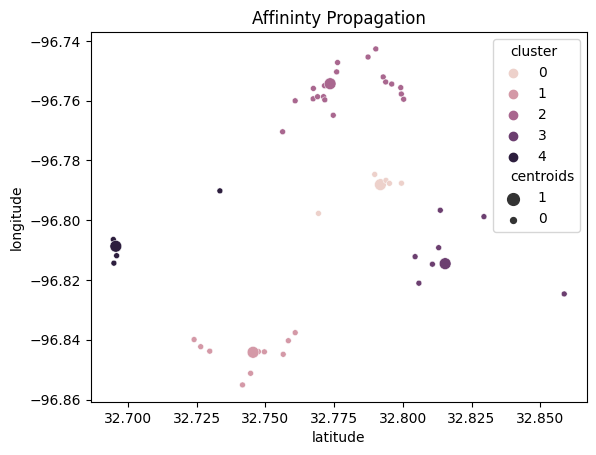

In [11]:
X = dtf[["latitude","longitude"]]
## clustering
dtf_X = X.copy()

dtf_X["cluster"] = model.fit_predict(X)
## find real centroids

closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(5)
sns.scatterplot(x="latitude", y="longitude", data=dtf, 
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief").set_title('Affininty Propagation')
      

In [12]:
x, y = "latitude", "longitude"
color = "cluster"
size = "products"
popup = "street"
marker = "centroids"
data = dtf.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_